# Neural Collaborative Filtering (NCF)

This examples trains a neural network on the MovieLens data set using the concept of [Neural Collaborative Filtering (NCF)](https://dl.acm.org/doi/abs/10.1145/3038912.3052569) that is aimed at approaching recommendation problems using deep neural networks as opposed to common matrix factorization approaches.

## Setup and Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Download Data - MovieLens

The MovieLens data set is provided by the Unniversity of Minnesota and the GroupLens Research Group:

> This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org/), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.<br/>
Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.<br/>
The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv. More details about the contents and use of all these files follows.<br/>
This is a development dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available benchmark datasets if that is your intent.<br/>
This and other GroupLens data sets are publicly available for download at http://grouplens.org/datasets/.

In [3]:
%%sh
DATASET=ml-latest-small

mkdir -p data/$DATASET/
cd data/$DATASET
curl -O http://files.grouplens.org/datasets/movielens/$DATASET.zip
unzip $DATASET.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   640k      0  0:00:01  0:00:01 --:--:--  640k


## Prepare Data

In [19]:
data_loc = "data/ml-latest-small/ml-latest-small/"
negative_split = 1.5  # how many negatives for one positive

# load interactions from MovieLens
raw_ratings = pd.read_csv(data_loc + "ratings.csv")
positives = pd.DataFrame(raw_ratings, columns=['userId', 'movieId'])

# sample negatives
negatives = pd.DataFrame(columns=["userId", "movieId"])

while len(negatives) < len(positives) * negative_split:
    user = positives["userId"].sample().values[0]
    movie = positives["movieId"].sample().values[0]
    if len(positives.loc[(positives["userId"] == user) & (positives["movieId"] == movie)]) == 0:
        negatives = negatives.append({"userId": user, "movieId": movie}, ignore_index=True)

# write out final data
targets = np.hstack([np.ones(len(positives)), np.zeros(len(negatives))])
all_ratings = np.vstack([positives, negatives])

user_item_targets = np.hstack([all_ratings, targets[:, np.newaxis]])

np.random.shuffle(user_item_targets)

split = train_test_split(user_item_targets, train_size=0.8)

np.savetxt(data_loc + "sampled-train.csv", split[0], delimiter=",")
np.savetxt(data_loc + "sampled-test.csv", split[1], delimiter=",")

## SystemDS NCF implementation

### Train

#### with synthetic dummy data

In [13]:
%%bash
cd ../../..
bin/systemds target/SystemDS.jar scripts/nn/examples/ncf-dummy-data.dml > scripts/nn/examples/run_log.txt && cat scripts/nn/examples/run_log.txt

Using user supplied systemds jar file target/SystemDS.jar
###############################################################################
#  SYSTEMDS_ROOT= .
#  SYSTEMDS_JAR_FILE= target/SystemDS.jar
#  CONFIG_FILE= --config ./target/testTemp/org/apache/sysds/api/mlcontext/MLContext/SystemDS-config.xml
#  LOG4JPROP= -Dlog4j.configuration=file:conf/log4j-silent.properties
#  CLASSPATH= target/SystemDS.jar:./lib/*:./target/lib/*
#  HADOOP_HOME= /Users/patrick/Uni Offline/Architectures of Machine Learning Systems (AMLS)/systemml/target/lib/hadoop
#
#  Running script scripts/nn/examples/ncf-dummy-data.dml locally with opts: 
###############################################################################
Executing command:     java       -Xmx4g      -Xms4g      -Xmn400m   -cp target/SystemDS.jar:./lib/*:./target/lib/*   -Dlog4j.configuration=file:conf/log4j-silent.properties   org.apache.sysds.api.DMLScript   -f scripts/nn/examples/ncf-dummy-data.dml   -exec singlenode   --config ./target/t

20/05/28 15:04:03 INFO api.DMLScript: BEGIN DML run 05/28/2020 15:04:03
20/05/28 15:04:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
20/05/28 15:04:13 INFO api.DMLScript: END DML run 05/28/2020 15:04:13


#### with real data

In [ ]:
%%bash
cd ../../..
bin/systemds target/SystemDS.jar scripts/nn/examples/ncf-real-data.dml > scripts/nn/examples/run_log.txt && cat scripts/nn/examples/run_log.txt

 ### Plot training results

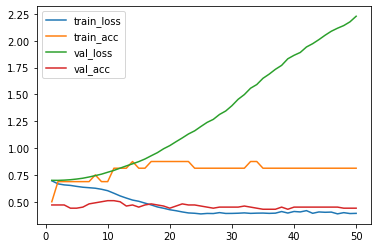

In [14]:
log_name = "run_log"
txt_name = log_name + ".txt"
csv_name = log_name + ".csv"

# convert to CSV
with open(txt_name, "r") as txt_file:
    data = txt_file.readlines()
    csv_lines = list(map(lambda x: x.replace("Epoch: ", "")
                         .replace(", Iter: ", ",")
                         .replace(", Train Loss: ", ",")
                         .replace(", Train Accuracy: ", ",")
                         .replace(", Val Loss: ", ",")
                         .replace(", Val Accuracy: ", ","),
                            filter(lambda x: "Epoch: " in x, data)))
    with open(csv_name, "w") as csv_file:
        csv_file.write("epoch,iter,train_loss,train_acc,val_loss,val_acc\n")
        for item in csv_lines:
            csv_file.write("%s" % item)

# plot
log = pd.read_csv(csv_name)
plot_log = log[log["iter"] == 1]

for val in ["train_loss", "train_acc", "val_loss", "val_acc"]:
    plt.plot(plot_log["epoch"], plot_log[val], label=val)

plt.legend()
plt.show()